Explicaciones visuales via GradCAM
===============================

## Introducción

A pesar de su amplia adopción, los modelos de aprendizaje automático - y especialmente aquellos basados en aprendizaje profundo - siguen siendo cajas negras a la hoja de entender como toman las decisiones que toman 1 . Sin embargo, comprender las razones detrás de las predicciones es importante para evaluar la confianza, que es fundamental si uno planea tomar acciones basadas en una predicción o al elegir si implementar un nuevo modelo en el contexto de una organización o proceso de negocio. Esta comprensión también proporciona información sobre el modelo, que se puede utilizar para transformar un modelo o una predicción que no son confiables en uno confiable.

### Preparación del ambiente

Intalamos las librerias necesarias

In [1]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/vision/tasks/classification/code/cnn_class.txt \
    --quiet --no-clobber
!pip install -r cnn_class.txt --quiet

### Sobre el conjunto de datos de este ejemplo

Origen: https://www.tensorflow.org/datasets/catalog/horses_or_humans

Podemos cargar este conjunto de datos facilmente utilizando `tensorflow-datasets`:

In [123]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

ds, info = tfds.load('horses_or_humans', split='train', shuffle_files=True, with_info=True)

In [3]:
print("Numero de clases: ", info.features["label"].num_classes)
print("Clases disponibles: ", info.features["label"].names)

Numero de clases:  2
Clases disponibles:  ['horses', 'humans']


Veamos algunos ejemplos:

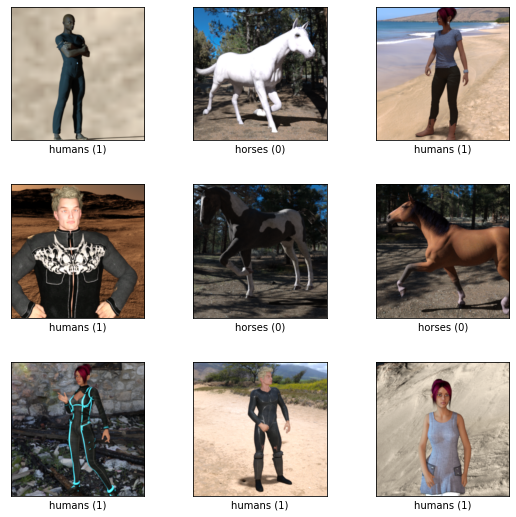

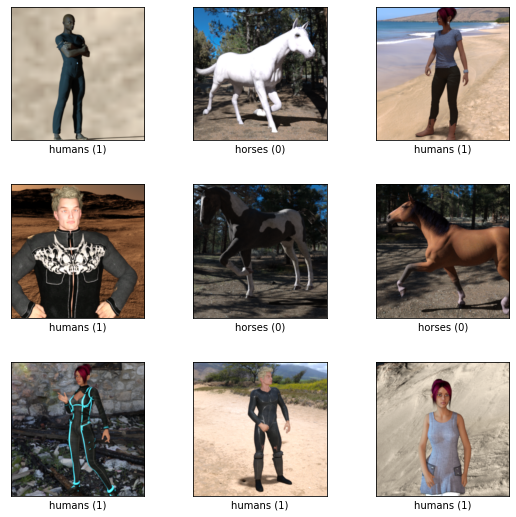

In [4]:
tfds.show_examples(ds, info)

## Construcción de una red neuronal convolucional

### Entendiendo una estructura basada en CNN estandar

Generaremos una red basada en CNNs de 3 bloques concatenados. En este caso la misma constará de:
 - 3 bloques de:
   - 2 capas de CNN
   - 1 capas de Pooling
 - 1 capa de regularización
 - Una red de 2 capas fully-connected

In [5]:
from tensorflow.keras.layers.experimental import preprocessing

In [6]:
def buildModel():
    model = keras.models.Sequential(
      [
         # BLOQUE 1
         keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(300,300,3)),
         keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
         keras.layers.MaxPooling2D((2, 2)), # Me quedo con 1/4

         # BLOQUE 2
         keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
         keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
         keras.layers.MaxPooling2D((2, 2)), # Me quedo con 1/4

         # BLOQUE 3
         keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
         keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
         keras.layers.MaxPooling2D((2, 2)), # Me quedo con 1/4

         # CLASIFICADOR NORMAL
         keras.layers.Flatten(),
         keras.layers.Dropout(0.5),
         keras.layers.Dense(128, activation='relu'),
         keras.layers.Dense(2, activation='softmax')
      ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

Instanciamos nuestro modelo y verificamos su arquitectura

In [7]:
model = buildModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                    

Antes de comenzar el entrenamiento, configuraremos nuestro conjunto de datos para una tarea supervisada. Esto lo hacemos especificando el parametro *as_supervised=True* lo cual nos da la posibilidad de acceder a las anotaciones del conjunto de datos.

In [8]:
(training_set, validation_set) = tfds.load('horses_or_humans', split=['train', 'test'], as_supervised=True)

Configuramos los parametros de entrenamiento:

> Note que utilizamos una función para normalizar la entrada

In [9]:
BATCH_SIZE=64
EPOCHS = 3

normalizer = preprocessing.Rescaling(scale=1./255)

def normalize(x, y):
  return normalizer(x), y

training_set_batch = training_set.map(normalize).batch(batch_size=BATCH_SIZE).cache().repeat()
validation_set_batch = validation_set.map(normalize).batch(batch_size=BATCH_SIZE).cache().repeat()
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

Comenzamos el entrenamiento

In [10]:
history = model.fit(training_set_batch, 
                    epochs=EPOCHS,
                    steps_per_epoch=train_size,
                    validation_data=validation_set_batch,
                    validation_steps=test_size)

Epoch 1/3
1027/1027 [==============================] - 516s 485ms/step - loss: 0.0346 - accuracy: 0.9882 - val_loss: 11.3619 - val_accuracy: 0.8008
Epoch 2/3
1027/1027 [==============================] - 501s 487ms/step - loss: 2.9413e-07 - accuracy: 1.0000 - val_loss: 12.3109 - val_accuracy: 0.7969
Epoch 3/3
1027/1027 [==============================] - 499s 486ms/step - loss: 9.8957e-08 - accuracy: 1.0000 - val_loss: 13.0349 - val_accuracy: 0.7969


Guardamos el modelo que acabamos de entrenar

In [11]:
model.save("horses_humans.h5")

In [12]:
!zip horses_humans.zip horses_humans.h5

  adding: horses_humans.h5 (deflated 29%)


## Interpretando las predicciones

Cargamos el modelo en caso de que no lo hayamos entrenado aqui:

In [ ]:
model = tf.keras.models.load_model('horses_humans.h5')

Busquemos una imagen para probar el modelo

In [266]:
for example in ds.shuffle(1024).take(1):
  image, label = example["image"], example["label"]

Como es constumbre, necesitaremos ajustar la imagen a lo que espera nuestro modelo:

In [267]:
image_shape = (300, 300)

In [268]:
import numpy as np

input_img = keras.preprocessing.image.img_to_array(image) / 255.0
input_img = np.expand_dims(input_img, axis=0)

Veamos la imagen original

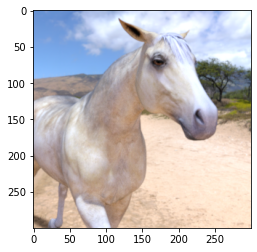

In [269]:
import matplotlib.pyplot as plt

plt.imshow(image)

Nos quedaremos con la ultima capa convolucional y construiremos un modelo que va desde la entrada hasta la misma:

In [270]:
last_conv_layer = model.get_layer("conv2d_5")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [271]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
classifier_output = model.get_layer("dense_1")
classifier_model = tf.keras.Model(last_conv_layer.output, classifier_output.output)

First, we get the output from the model up till the last convolution layer. We ask tf to watch this tensor output, as we want to calculate the gradients of the predictions of our target class wrt to the output of this model (last convolution layer model).

In [272]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(input_img)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [273]:
tf.argmax(model(input_img), axis=-1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

The partial derivative / gradient of the model output (logits / prior to softmax), 
, with respect to the feature map (filter) activations of a specified convolution layer (the last convolution layer in this case) is:

In [274]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

The gradients have a shape of (u,v,Z), where (u,v) comes from the shape of the 2D convolution filter (i.e. width and height), and Z is the number of filters. The next step averages each of the filters to a single value, so that the final shape is Z or the number of filters. This is equivalent to the global average pooling 2D layer.

In [275]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

This is what the next layer in the model does which is a global average pooling 2D layer, which averages and flattens the 
 number of filters of 
 shape to single numbers (exactly what we did in previous step). This is necessary to create a connection to the fully connected (Dense) layers for the final prediction outputs.

The next step is to multiply the gradients (corresponding to the importance of the given feature map / filter) with the actual feature map (filter) it represents.

In [276]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [277]:
import cv2

In [278]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (300, 300))

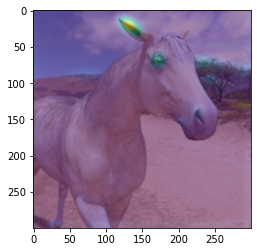

In [280]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5)